### 在資料集上測試 (MVtech)
資料集: 
> THE MVTEC ANOMALY DETECTION DATASET (MVTEC AD)
> https://www.mvtec.com/company/research/datasets/mvtec-ad


<img src="https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/dataset_overview_large.png" alt="drawing" width="400"/>

In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential, layers
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from functools import partial
from IPython.display import display

from sklearn.model_selection import train_test_split

from unet import UNet

import albumentations as A
from albumentations import DualTransform
from typing_extensions import Concatenate
from typing_extensions import Concatenate

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
BATCH_SIZE = 16
NUM_LABELS = 1
WIDTH = 128
HEIGHT = 128
MULTI_CHANNELS = False

In [5]:
unet = UNet(num_class=1, padding='same', retain_dim=(WIDTH, HEIGHT))
x = np.zeros((1, HEIGHT, WIDTH, 3), dtype=np.float32)
y_pred = unet(x)
print(y_pred.shape)
del unet

2023-03-09 18:06:48.289103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 18:06:48.951753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
2023-03-09 18:06:49.445535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


(1, 128, 128, 1)


In [6]:
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

2:80: E501 line too long (151 > 79 characters)


In [7]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### 取得image list
輸出: data_dic (字典)
- key: X_train, X_test, y_train, y_test

In [8]:
mask_dir = lambda anno_dir, X_lis: [anno_dir+i.split('.')[0]+'_mask.png'
                                    for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

size = 1/len(imgs_path_list)
size = 0.1
train, test = train_test_split(imgs_path_list, train_size=size, random_state=0)

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
    lis.append([img_dir+i for i in number])  # X
for number in [train, test]:
    lis.append(mask_dir(anno_dir, number))  # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/project/ta-hsi-datacenter3/course_3.0/05_CVCNN/Part6_Segmentation_Detection/data/capsule/test/scratch/015.png',
 '/project/ta-hsi-datacenter3/course_3.0/05_CVCNN/Part6_Segmentation_Detection/data/capsule/test/scratch/012.png']

1:1: E731 do not assign a lambda expression, use a def


### Build dataset

In [9]:
def data_generater(imgs_path_list, anno_path_list, img_transform=None):
    for img_path in imgs_path_list:
        img_path = str(bytes.decode(img_path))
        file_name = img_path.split('/')[-1].split('.')[0]
        mask_path = [str(bytes.decode(i))
                     for i in anno_path_list
                     if str(i).__contains__(file_name)][0]
        # csv
        image = cv2.imread(img_path)
        image = np.array(image, dtype=np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (1000, 1000)
        mask = np.array(mask, dtype=np.float32)

        if img_transform == 1:
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        elif img_transform == 2:
            transformed = target_transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        image = tf.constant(image)

        mask = tf.constant(mask)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = mask/255.
        yield image, mask

### 使用 albumentations 進行資料擴增

In [11]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
    A.CenterCrop(300, 900, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate((-30, 30), interpolation=0),
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

In [12]:
# 建議同時間只有16個(128,128)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)
BATCH_SIZE = 16
MULTI_CHANNELS = False

# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配，接著透過CustomImageDataset的transform做資料擴增
if len(data_dic['X_train']) < 16:
    lis = data_dic['X_train']
    lis = [lis[i % len(lis)] for i in range(BATCH_SIZE)]
    data_dic['X_train'] = lis

train_ds = tf.data.Dataset.from_generator(
    data_generater,
    output_signature=(tf.TensorSpec(shape=(None, None, 3),
                                    dtype=tf.float32),
                      tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)),
    args=[data_dic['X_train'], data_dic['y_train'], 1])

test_ds = tf.data.Dataset.from_generator(
    data_generater, output_signature=(tf.TensorSpec(shape=(None, None, 3),
                                                    dtype=tf.float32),
                                      tf.TensorSpec(shape=(None, None, 1),
                                                    dtype=tf.float32)),
    args=[data_dic['X_test'], data_dic['y_test'], 2])

# 如果要正式使用要記得把 test_ds 的資料換成換成 X_test

dataset_train = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=32)
dataset_test = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=32)

In [13]:
for batch in dataset_train.take(1):
    print(f'{len(batch)}, {batch[0].shape}, {batch[1].shape}')

2, (16, 128, 128, 3), (16, 128, 128, 1)


#### 補充: 如何從dataset抽image, mask出來

In [15]:
def show_image_mask(*img_list, split=False):
    plt.figure(figsize=(10, 3))
    for i, img in enumerate(list(img_list), 1):
        plt.subplot(1, len(img_list), i)
        img = img - img.min()
        if len(np.shape(img)) == 2:
            plt.imshow(img, cmap='gray')
        else:
            img = img.astype(np.int32)
            plt.imshow(img)
    plt.show()
    plt.close()

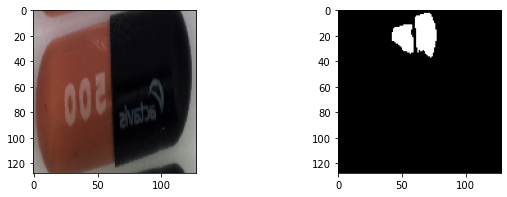

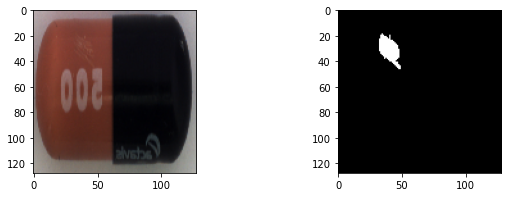

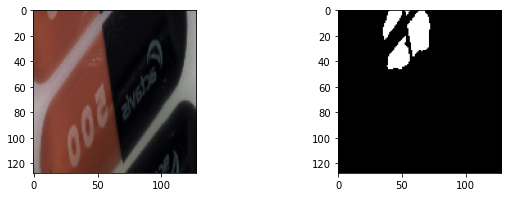

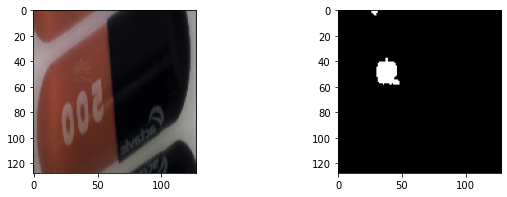

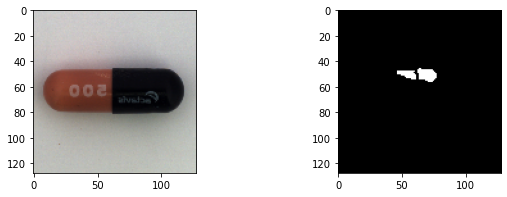

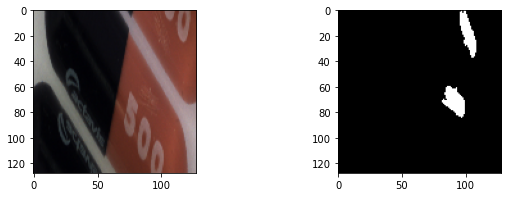

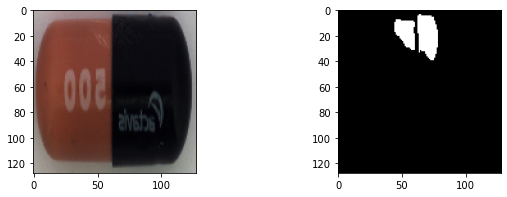

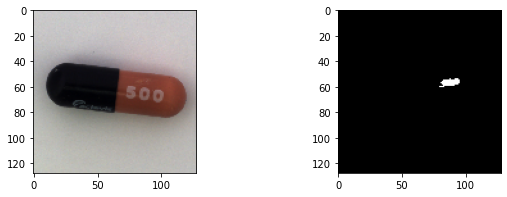

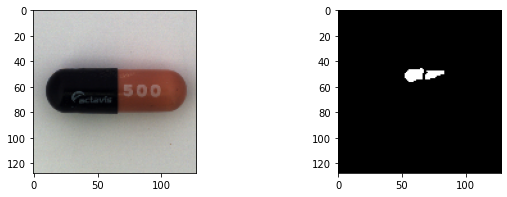

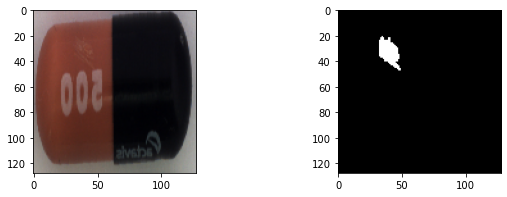

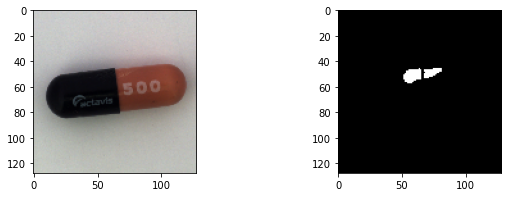

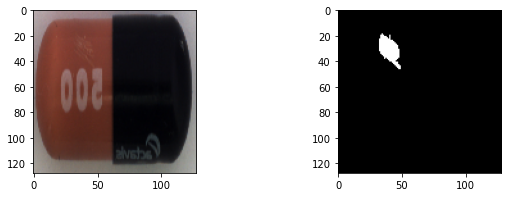

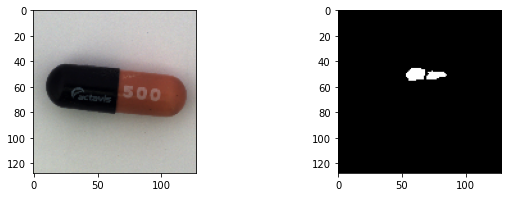

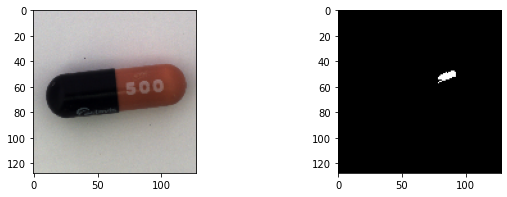

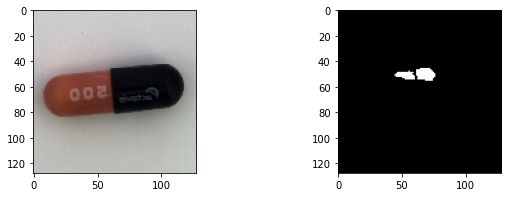

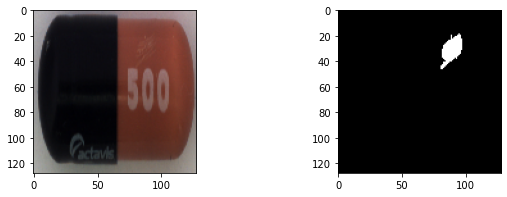

In [16]:
for batch in dataset_train.take(1):
    for image, mask in zip(batch[0], batch[1]):
        show_image_mask(image.numpy(), mask.numpy().squeeze())

# 訓練模型

In [19]:
model = UNet(num_class=1, padding='same', retain_dim=(WIDTH, HEIGHT))

loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_fn)
model.fit(dataset_train, batch_size=16, epochs=500)
# model.save_weights('UNet')

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7026
Epoch 2/5
1/1 [==============================] - 1s 927ms/step - loss: 66.0442
Epoch 3/5
1/1 [==============================] - 1s 905ms/step - loss: 0.6881
Epoch 4/5
1/1 [==============================] - 1s 884ms/step - loss: 0.5563
Epoch 5/5
1/1 [==============================] - 1s 869ms/step - loss: 0.4383


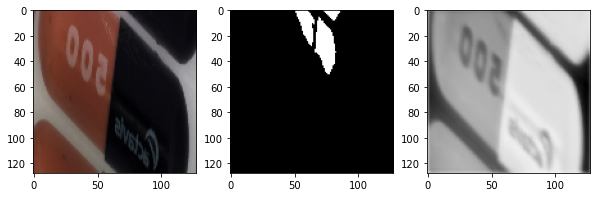

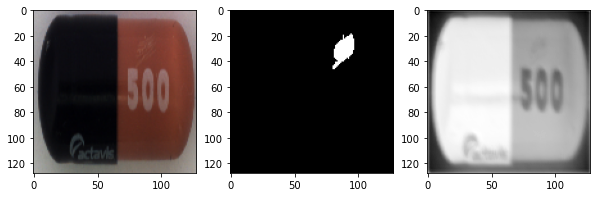

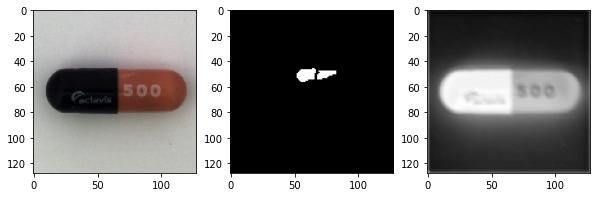

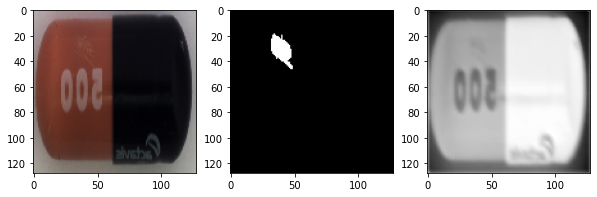

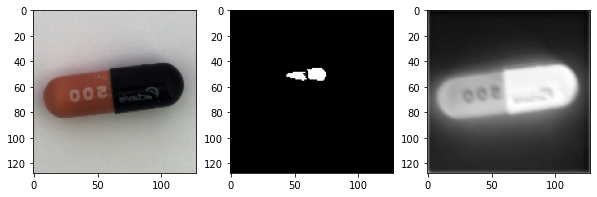

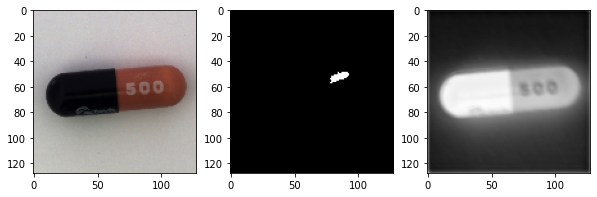

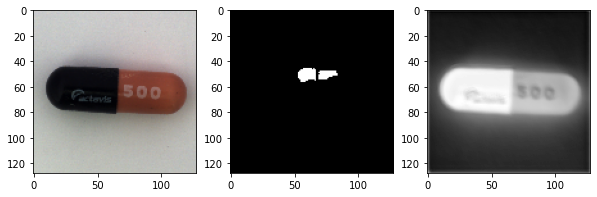

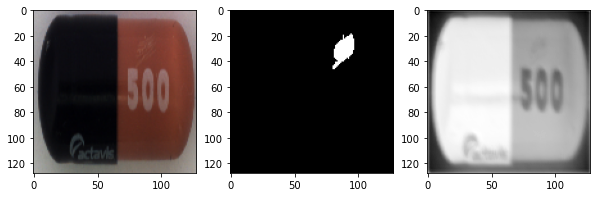

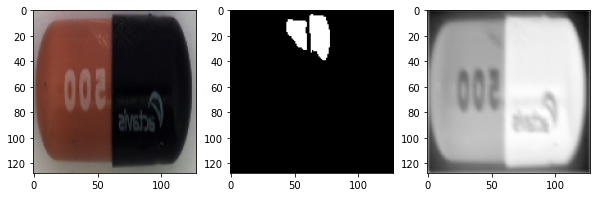

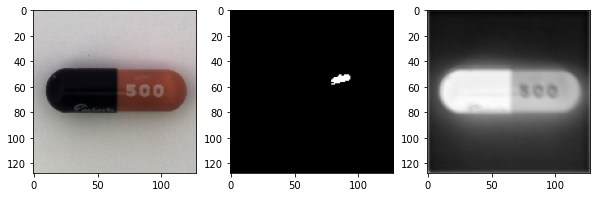

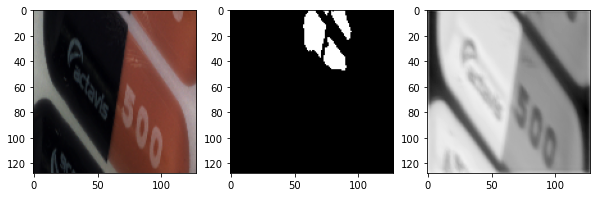

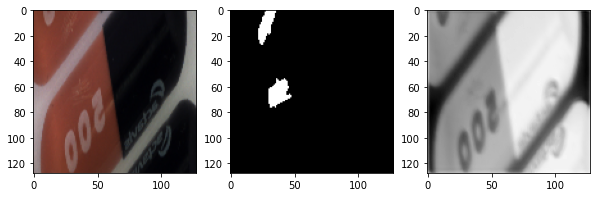

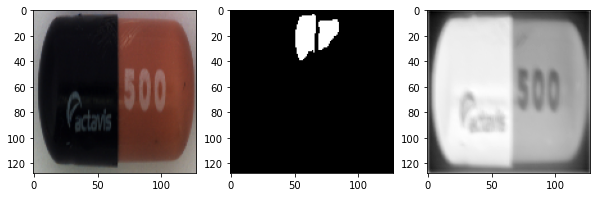

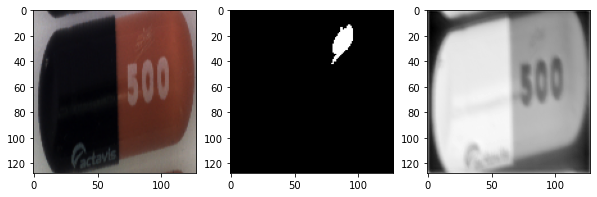

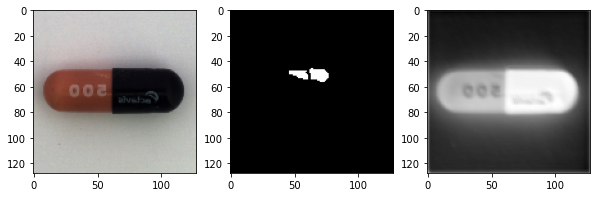

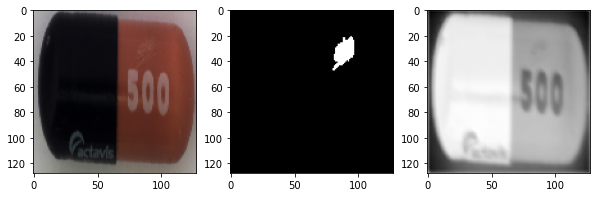

In [21]:
for batch in dataset_train.take(1):
    for image, mask in zip(batch[0], batch[1]):
        pre = model(np.expand_dims(image, 0)).numpy()
#         pre[pre>=0.2] = 1
#         pre[pre<0.2] = 0
        show_image_mask(image.numpy(), mask.numpy().squeeze(), pre.squeeze())